### Import Library dan Dataset

In [1]:
import os
import gc
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_USE_LEGACY_KERAS"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"
os.environ["HF_HUB_OFFLINE"] = "1"

In [2]:
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
from optuna.trial import TrialState
import warnings
warnings.filterwarnings('ignore')

I0000 00:00:1764253294.535459  450380 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
I0000 00:00:1764253294.617758  450380 cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1764253296.605032  450380 port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/sorr/anaconda3/envs/nightly_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProg

In [3]:
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
# GPU memory growth (safe for tf-nightly)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception as e:
            print("Warning: set_memory_growth failed:", e)

# Mixed precision (optional, often supported in tf-nightly)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision unavailable or failed:", e)

# helper to free memory between trials/folds


def free_mem():
    try:
        tf.keras.backend.clear_session()
    except Exception:
        pass
    gc.collect()


print("TensorFlow version:", tf.__version__)
print("Num GPUs:", len(gpus))

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 5070, compute capability 12.0
Mixed precision enabled: <Policy "mixed_float16">
TensorFlow version: 2.21.0-dev20251013
Num GPUs: 1


W0000 00:00:1764253299.940244  450380 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.


In [5]:
df = pd.read_csv('../data/data_cleaned.csv')
df.head()

,Tweet,Label
0,terlepas kadang alurnya bikin kesal tapi terim...,Cinta
1,bagian terseram caraka malam ditengah hutan be...,Takut
2,saya sadar saya ini siapa kamu siapa dan takka...,Sedih
3,kalau memang tak ada niatan lebih tolong janga...,Sedih
4,sekuat kuatnya orang yang selalu riang tertawa...,Sedih


### Persiapan Dataset

In [6]:
le = LabelEncoder()
df['LabelEncoded'] = le.fit_transform(df['Label'])
label_names = le.classes_.tolist()
num_labels = len(label_names)

print(f"Total samples: {len(df)}")
print(f"Number of labels: {num_labels}")
print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Total samples: 9342
Number of labels: 5
Label mapping: {'Cinta': np.int64(0), 'Gembira': np.int64(1), 'Marah': np.int64(2), 'Sedih': np.int64(3), 'Takut': np.int64(4)}


In [7]:
train_val_texts, test_texts, train_val_labels, test_labels = train_test_split(
    df["Tweet"].tolist(),
    df["LabelEncoded"].tolist(),
    test_size=0.15,  # 15% = 1500 samples untuk test
    stratify=df["LabelEncoded"],
    random_state=42
)

# Split train_val menjadi train dan val
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_val_texts, train_val_labels,
    test_size=0.1765,  # 15% dari total = 1000 samples
    stratify=train_val_labels,
    random_state=42
)

print(f"Train: {len(train_texts):,} samples")
print(f"Val: {len(val_texts):,} samples")
print(f"Test: {len(test_texts):,} samples (UNTOUCHED)")

Train: 6,538 samples
Val: 1,402 samples
Test: 1,402 samples (UNTOUCHED)


### Load Tokenizer

In [8]:
LOCAL_DIR = "../local-indobert-tf"
tokenizer = AutoTokenizer.from_pretrained(LOCAL_DIR)

### Define Function CV

In [9]:
def create_efficient_dataset(texts, labels, batch_size=8, max_length=96):
    """Membuat dataset secara efisien"""
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors="tf"
    )

    dataset = tf.data.Dataset.from_tensor_slices((
        dict(encodings),
        tf.convert_to_tensor(labels)
    )).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset


def objective(trial):
    """Objective function tanpa CV - menggunakan fixed validation set"""

    # Hyperparameter space
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    max_length = trial.suggest_categorical("max_length", [64, 96, 128])
    epochs = trial.suggest_int("epochs", 3, 6)

    print(
        f"  Trial {trial.number} - LR: {learning_rate:.2e}, Batch: {batch_size}, Epochs: {epochs}")

    # Buat datasets menggunakan fixed train/val split (bukan CV)
    train_dataset = create_efficient_dataset(
        train_texts, train_labels, batch_size, max_length)
    val_dataset = create_efficient_dataset(
        val_texts, val_labels, batch_size, max_length)

    # Buat model
    model = TFAutoModelForSequenceClassification.from_pretrained(
        LOCAL_DIR,
        num_labels=num_labels,
        local_files_only=True
    )

    # FIX: Gunakan optimizer yang compatible
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

    # Training dengan early stopping
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        verbose=0,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True,
                verbose=0
            )
        ]
    )

    # Gunakan best validation accuracy (bukan epoch terakhir)
    best_val_accuracy = max(history.history['val_accuracy'])

    print(f"    Val Accuracy: {best_val_accuracy:.4f}")

    # Clear memory
    tf.keras.backend.clear_session()
    del model

    return best_val_accuracy

### Define Function Objective

In [10]:
study = optuna.create_study(
    direction='maximize',  # Maximize accuracy
    storage="sqlite:///indobert.db",
    study_name="indobert",
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42),
)

N_TRIALS = 20

[I 2025-11-27 21:21:40,866] Using an existing study with name 'indobert' instead of creating a new one.


In [11]:
completed = len([t for t in study.trials if t.state == TrialState.COMPLETE])
remaining = max(0, N_TRIALS - completed)
print("Completed:", completed, "Remaining to run:", remaining)

Completed: 20 Remaining to run: 0


### Hyperparameter TUning

In [12]:
print("Starting Hyperparameter Optimization...")
study.optimize(objective, 
               n_trials=remaining, 
               show_progress_bar=True)

Starting Hyperparameter Optimization...


In [13]:
# Print results
print("\n" + "="*60)
print("BEST HYPERPARAMETERS (INCLUDING EPOCH)")
print("="*60)
print(f"Best CV Accuracy: {study.best_value:.4f}")
print("\nBest Hyperparameters:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

best_params = study.best_trial.params


BEST HYPERPARAMETERS (INCLUDING EPOCH)
Best CV Accuracy: 0.8062

Best Hyperparameters:
  learning_rate: 1.980903606207815e-06
  batch_size: 8
  max_length: 64
  epochs: 5


In [14]:
print("\n" + "="*50)
print("ALL TRIALS ANALYSIS")
print("="*50)
trials_df = study.trials_dataframe()
trials_df = trials_df.sort_values('value', ascending=False)
print(trials_df[['number', 'value', 'params_learning_rate', 'params_batch_size',
                 'params_epochs', 'params_max_length']].head(10))


ALL TRIALS ANALYSIS
    number     value  params_learning_rate  params_batch_size  params_epochs  \
18      18  0.806210              0.000002                  8              5   
2        2  0.801927              0.000003                  8              4   
4        4  0.801927              0.000001                 16              4   
11      11  0.801927              0.000003                 16              4   
14      14  0.800857              0.000002                  8              4   
12      12  0.798715              0.000003                 16              4   
7        7  0.798715              0.000001                 32              4   
8        8  0.798715              0.000003                 32              3   
9        9  0.798715              0.000001                  8              3   
5        5  0.798715              0.000002                 32              5   

    params_max_length  
18                 64  
2                  64  
4                 128  
11

### Trai final Model

In [15]:
# Split data untuk final training
print(f"Using BEST parameters from Optuna:")
for key, value in best_params.items():
    print(f"  {key}: {value}")

# Gunakan seluruh train_val data untuk training final
print(f"Training final model on {len(train_val_texts):,} samples...")

Using BEST parameters from Optuna:
  learning_rate: 1.980903606207815e-06
  batch_size: 8
  max_length: 64
  epochs: 5
Training final model on 7,940 samples...


In [16]:
# Buat dataset final dengan best parameters
final_train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding='max_length',
    max_length=best_params['max_length'],
    return_tensors="tf"
)

final_val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding='max_length',
    max_length=best_params['max_length'],
    return_tensors="tf"
)

final_train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(final_train_encodings),
    tf.convert_to_tensor(train_labels)
)).shuffle(1000).batch(best_params['batch_size']).prefetch(tf.data.AUTOTUNE)

final_val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(final_val_encodings),
    tf.convert_to_tensor(val_labels)
)).batch(best_params['batch_size']).prefetch(tf.data.AUTOTUNE)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
W0000 00:00:1764253301.160503  450380 gpu_device.cc:2456] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 12.0a. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
I0000 00:00:1764253301.320813  450380 gpu_device.cc:2040] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9129 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070, pci bus id: 0000:01:00.0, compute capability: 12.0a


In [17]:
# Buat model final
final_model = TFAutoModelForSequenceClassification.from_pretrained(
    LOCAL_DIR,
    num_labels=num_labels,
    local_files_only=True
)

final_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=best_params['learning_rate']),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [18]:
# Training
print("Starting final training")
history_final = final_model.fit(
    final_train_dataset,
    validation_data=final_val_dataset,
    epochs=3,
    verbose=1
)


Starting final training
Epoch 1/3


E0000 00:00:1764253320.245534  450380 util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.
I0000 00:00:1764253321.651934  450597 service.cc:158] XLA service 0x70de4807c570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764253321.651971  450597 service.cc:166]   StreamExecutor device (0): NVIDIA GeForce RTX 5070, Compute Capability 12.0a
I0000 00:00:1764253321.675311  450598 dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1764253321.699860  450598 cuda_dnn.cc:463] Loaded cuDNN version 91400
I0000 00:00:1764253321.809226  450592 device_compiler.h:208] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


818/818 [==============================] - 143s 145ms/step - loss: 1.0765 - accuracy: 0.6000 - val_loss: 0.6943 - val_accuracy: 0.7518
Epoch 2/3
818/818 [==============================] - 109s 133ms/step - loss: 0.5929 - accuracy: 0.7964 - val_loss: 0.5914 - val_accuracy: 0.7939
Epoch 3/3
818/818 [==============================] - 110s 135ms/step - loss: 0.4874 - accuracy: 0.8354 - val_loss: 0.5828 - val_accuracy: 0.7967


In [19]:
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding='max_length',
    max_length=best_params['max_length'],
    return_tensors="tf"
)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    tf.convert_to_tensor(test_labels)
)).batch(best_params['batch_size']).prefetch(tf.data.AUTOTUNE)

### Evaluasi

In [20]:
test_loss, test_accuracy = final_model.evaluate(test_dataset, verbose=0)

print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Epochs Used: 3")



FINAL RESULTS
Test Loss: 0.6115
Test Accuracy: 0.7732
Epochs Used: 3


In [21]:
# Predictions dan detailed report
pred_logits = final_model.predict(test_dataset, verbose=0).logits
pred_labels = np.argmax(pred_logits, axis=1)

print("\nCLASSIFICATION REPORT:")
print(classification_report(test_labels, pred_labels,
                            target_names=label_names, digits=4))


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Cinta     0.6808    0.8510    0.7564       208
     Gembira     0.8077    0.7412    0.7730       340
       Marah     0.8018    0.8416    0.8212       322
       Sedih     0.7176    0.6288    0.6702       299
       Takut     0.8522    0.8412    0.8467       233

    accuracy                         0.7732      1402
   macro avg     0.7720    0.7807    0.7735      1402
weighted avg     0.7757    0.7732    0.7719      1402



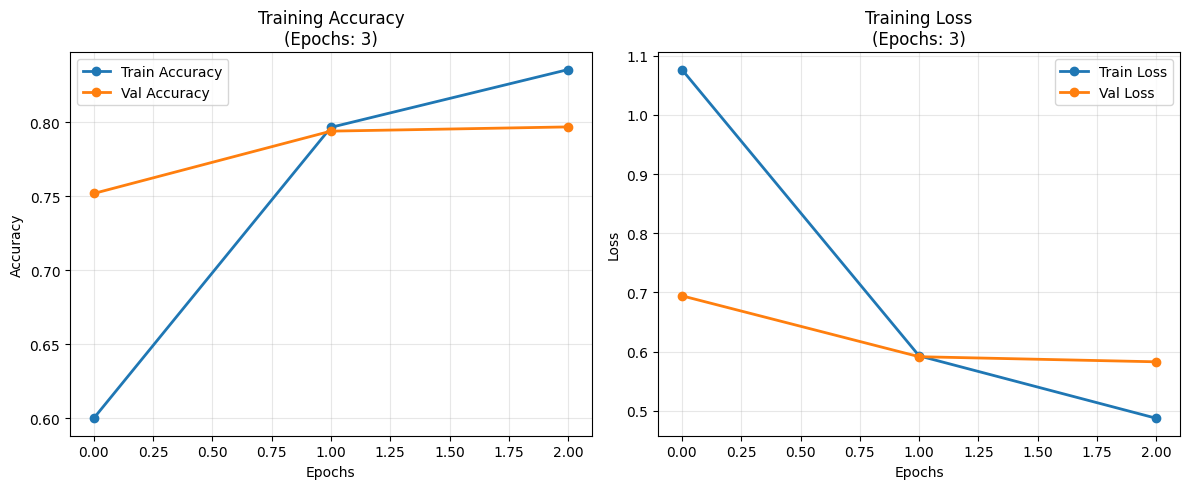

In [22]:
# Plot 4: Training History Final Model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_final.history['accuracy'],
         label='Train Accuracy', marker='o', linewidth=2)
plt.plot(history_final.history['val_accuracy'],
         label='Val Accuracy', marker='o', linewidth=2)
plt.title(f'Training Accuracy\n(Epochs: 3)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Train Loss',
         marker='o', linewidth=2)
plt.plot(history_final.history['val_loss'], label='Val Loss',
         marker='o', linewidth=2)
plt.title(f'Training Loss\n(Epochs: 3)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

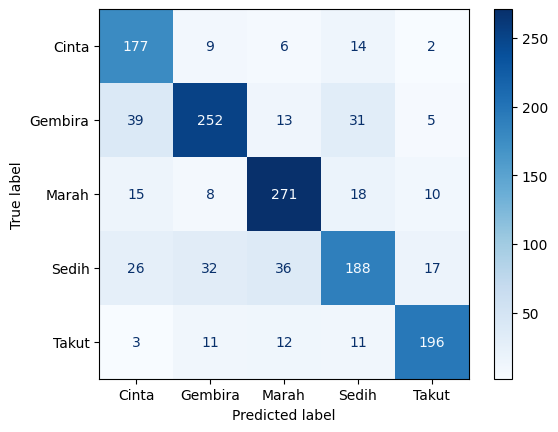

In [23]:
cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)

In [24]:
SAVE_DIR = "./IndoBert_Model"

os.makedirs(SAVE_DIR, exist_ok=True)

final_model.save_pretrained(f'{SAVE_DIR}')
tokenizer.save_pretrained(f'{SAVE_DIR}')

('./IndoBert_Model/tokenizer_config.json',
 './IndoBert_Model/special_tokens_map.json',
 './IndoBert_Model/vocab.txt',
 './IndoBert_Model/added_tokens.json',
 './IndoBert_Model/tokenizer.json')

### Inferensi Model

In [25]:
MODEL_PATH = './IndoBert_Model/'
TOKENIZER_PATH = './IndoBert_Model/'

In [26]:
#Load tokenizer dan model
tokenizer = AutoTokenizer.from_pretrained(SAVE_DIR)
model = TFAutoModelForSequenceClassification.from_pretrained(SAVE_DIR)

Some layers from the model checkpoint at ./IndoBert_Model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./IndoBert_Model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [27]:
EXTERNAL_TEST_PATH = "../data/external_test.csv"

try:
    # Load external dataset
    external_df = pd.read_csv(EXTERNAL_TEST_PATH)

    # Cek struktur dataset
    print(f"External dataset shape: {external_df.shape}")
    print(f"Columns: {external_df.columns.tolist()}")
    print(f"First few rows:")
    print(external_df.head())

    # Asumsi format: harus ada kolom 'Tweet' dan 'Label'
    if 'Tweet' not in external_df.columns or 'Label' not in external_df.columns:
        print("❌ Error: External dataset must have 'Tweet' and 'Label' columns")
        # Jika format berbeda, adjust sesuai kebutuhan
        # Contoh: jika kolom bernama 'text' dan 'sentiment'
        if 'text' in external_df.columns and 'sentiment' in external_df.columns:
            print("⚠️  Found 'text' and 'sentiment' columns, renaming...")
            external_df = external_df.rename(
                columns={'text': 'Tweet', 'sentiment': 'Label'})
        else:
            # Cari kolom yang mungkin berisi text dan label
            text_col = None
            label_col = None
            for col in external_df.columns:
                if external_df[col].dtype == 'object' and len(external_df[col].iloc[0]) > 10:
                    text_col = col
                elif external_df[col].dtype == 'object' and len(external_df[col].iloc[0]) < 20:
                    label_col = col

            if text_col and label_col:
                print(
                    f"⚠️  Using '{text_col}' as Tweet and '{label_col}' as Label")
                external_df = external_df.rename(
                    columns={text_col: 'Tweet', label_col: 'Label'})
            else:
                raise ValueError(
                    "Could not identify text and label columns automatically")

    print(f"✅ External dataset loaded: {len(external_df)} samples")
    print(f"Class distribution in external data:")
    print(external_df['Label'].value_counts())

except FileNotFoundError:
    print(f"❌ Error: File not found at {EXTERNAL_TEST_PATH}")
    print("Please check the file path and try again.")
    exit()
except Exception as e:
    print(f"❌ Error loading external dataset: {str(e)}")
    exit()

External dataset shape: (2235, 2)
Columns: ['Label', 'Tweet']
First few rows:
   Label                                        Tweet
0  Cinta  saya sayang sama semua impian dan harapanmu
1  Cinta                            saya sayang halus
2  Cinta                            kamu adalah sobat
3  Cinta                              cinta kita arti
4  Cinta                             cinta kita tetap
✅ External dataset loaded: 2235 samples
Class distribution in external data:
Label
Cinta      473
Gembira    473
Marah      470
Takut      424
Sedih      395
Name: count, dtype: int64


In [28]:
from sklearn.preprocessing import LabelEncoder

# Cek label yang ada di external data
external_labels = external_df['Label'].unique()
print(f"Unique labels in external data: {external_labels}")

# Load label names dari model training (asumsi Anda punya)
# Jika tidak, kita akan menggunakan yang dari external data
try:
    # Coba load label names dari file atau gunakan default
    label_names = ['Cinta', 'Gembira', 'Marah',
                   'Sedih', 'Takut']  # Adjust sesuai training Anda
    print(f"Using label names from training: {label_names}")

    # Map external labels ke format training jika diperlukan
    label_mapping = {
        'love': 'Cinta', 'happy': 'Gembira', 'anger': 'Marah',
        'sad': 'Sedih', 'fear': 'Takut', 'joy': 'Gembira'
    }

    # Apply mapping jika ada perbedaan naming
    external_df['Label'] = external_df['Label'].map(
        label_mapping).fillna(external_df['Label'])

except:
    print("⚠️  Using labels from external data")
    label_names = sorted(external_df['Label'].unique())
    print(f"Label names: {label_names}")

# Encode labels
le = LabelEncoder()
le.fit(label_names)  # Fit dengan label names yang konsisten

try:
    external_df['LabelEncoded'] = le.transform(external_df['Label'])
    print("✅ Labels encoded successfully")
except ValueError as e:
    print(f"❌ Label encoding error: {str(e)}")
    print("This might indicate label mismatch between training and external data")
    print("Available labels in external data:", external_df['Label'].unique())
    print("Expected labels:", label_names)

    # Handle unknown labels
    unknown_labels = set(external_df['Label']) - set(label_names)
    print(f"Unknown labels: {unknown_labels}")

    # Filter hanya samples dengan known labels
    mask = external_df['Label'].isin(label_names)
    external_df = external_df[mask]
    external_df['LabelEncoded'] = le.transform(external_df['Label'])

    print(f"Filtered to {len(external_df)} samples with known labels")

print(f"Final external dataset: {len(external_df)} samples")

Unique labels in external data: ['Cinta' 'Gembira' 'Marah' 'Sedih' 'Takut']
Using label names from training: ['Cinta', 'Gembira', 'Marah', 'Sedih', 'Takut']
✅ Labels encoded successfully
Final external dataset: 2235 samples


In [29]:
# Tokenisasi external data
external_texts = external_df['Tweet'].tolist()
external_true_labels = external_df['LabelEncoded'].tolist()

print(f"Tokenizing {len(external_texts)} samples...")

Tokenizing 2235 samples...


In [30]:
# Tokenize dengan parameter yang sama seperti training
def tokenize_texts(texts):
    return tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=64,  # Gunakan max_length yang sama seperti training
        return_tensors="tf"
    )


external_encodings = tokenize_texts(external_texts)

# Buat dataset
external_dataset = tf.data.Dataset.from_tensor_slices((
    dict(external_encodings),
    tf.convert_to_tensor(external_true_labels)
)).batch(16).prefetch(tf.data.AUTOTUNE)  # Batch size sama seperti training

print("✅ External data prepared for inference")

✅ External data prepared for inference


In [31]:
# Evaluate model
external_loss, external_accuracy = final_model.evaluate(external_dataset, verbose=0)

print("\n" + "="*60)
print("EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE")
print("="*60)
print(f"External Test Loss: {external_loss:.4f}")
print(f"External Test Accuracy: {external_accuracy:.4f}")
print(f"Number of samples: {len(external_df)}")

# Predictions
print("\nGenerating predictions...")
pred_logits = final_model.predict(external_dataset, verbose=0).logits
pred_labels = np.argmax(pred_logits, axis=1)
pred_probs = tf.nn.softmax(pred_logits, axis=1)


EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE
External Test Loss: 0.7160
External Test Accuracy: 0.7687
Number of samples: 2235

Generating predictions...


In [32]:
# Classification Report
print("\nCLASSIFICATION REPORT (External Data):")
print(classification_report(
    external_true_labels,
    pred_labels,
    target_names=label_names,
    digits=4
))


CLASSIFICATION REPORT (External Data):
              precision    recall  f1-score   support

       Cinta     0.6974    0.4482    0.5457       473
     Gembira     0.7546    0.7865    0.7702       473
       Marah     0.7866    0.9489    0.8602       470
       Sedih     0.6433    0.7899    0.7091       395
       Takut     0.9741    0.8868    0.9284       424

    accuracy                         0.7687      2235
   macro avg     0.7712    0.7721    0.7627      2235
weighted avg     0.7712    0.7687    0.7608      2235



<Figure size 1000x800 with 0 Axes>

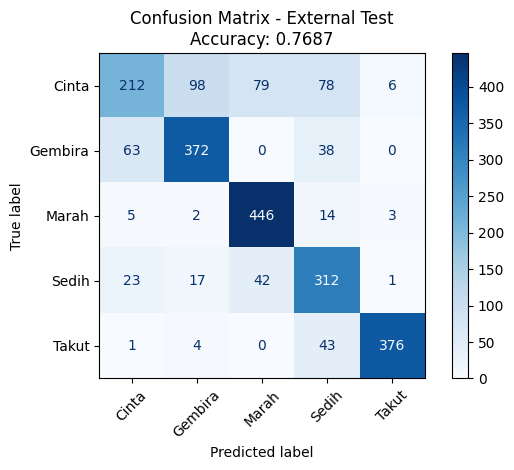

In [33]:
# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(external_true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title(
    f"Confusion Matrix - External Test\nAccuracy: {external_accuracy:.4f}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./external_test_confusion_matrix.png',
            dpi=300, bbox_inches='tight')
plt.show()

In [34]:
experiment_model = TFAutoModelForSequenceClassification.from_pretrained(
    LOCAL_DIR,
    num_labels=num_labels,
    local_files_only=True
)

experiment_model.compile(
    optimizer=tf.keras.optimizers.Adam(
        learning_rate=best_params['learning_rate']),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Some layers from the model checkpoint at ../local-indobert-tf were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ../local-indobert-tf.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [35]:
history_final = experiment_model.fit(
    final_train_dataset,
    validation_data=final_val_dataset,
    epochs=10,
    verbose=1
)

Epoch 1/10


818/818 [==============================] - 139s 149ms/step - loss: 1.0653 - accuracy: 0.6054 - val_loss: 0.6574 - val_accuracy: 0.7703
Epoch 2/10
818/818 [==============================] - 113s 138ms/step - loss: 0.5941 - accuracy: 0.7940 - val_loss: 0.5951 - val_accuracy: 0.7882
Epoch 3/10
818/818 [==============================] - 112s 137ms/step - loss: 0.4814 - accuracy: 0.8376 - val_loss: 0.5781 - val_accuracy: 0.7946
Epoch 4/10
818/818 [==============================] - 111s 135ms/step - loss: 0.3908 - accuracy: 0.8714 - val_loss: 0.5945 - val_accuracy: 0.7953
Epoch 5/10
818/818 [==============================] - 111s 135ms/step - loss: 0.3207 - accuracy: 0.8934 - val_loss: 0.6267 - val_accuracy: 0.7860
Epoch 6/10
818/818 [==============================] - 111s 136ms/step - loss: 0.2457 - accuracy: 0.9244 - val_loss: 0.6435 - val_accuracy: 0.7924
Epoch 7/10
818/818 [==============================] - 110s 134ms/step - loss: 0.1853 - accuracy: 0.9449 - val_loss: 0.7027 - val_accura

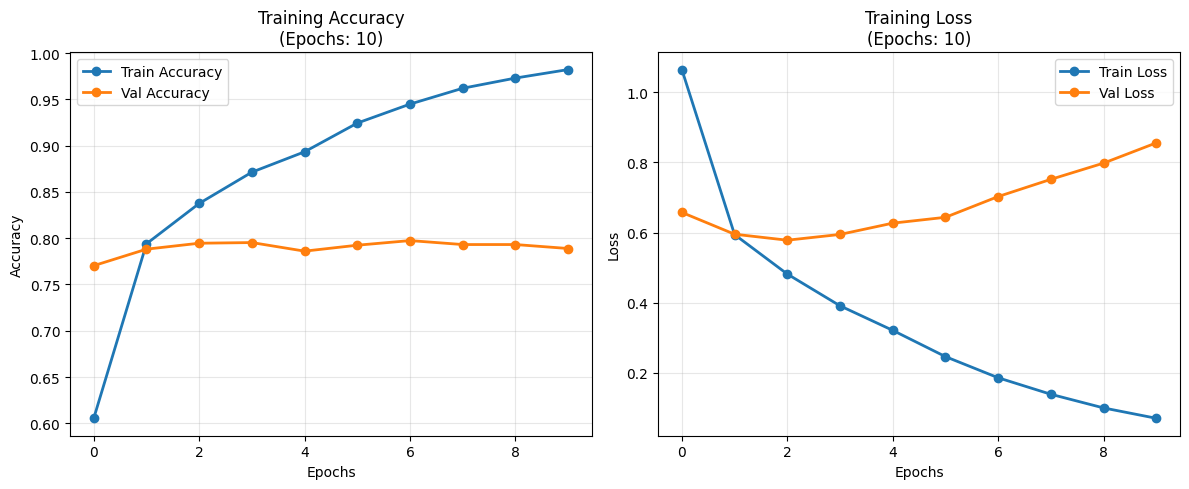

In [36]:
# Plot 4: Training History Final Model
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_final.history['accuracy'],
         label='Train Accuracy', marker='o', linewidth=2)
plt.plot(history_final.history['val_accuracy'],
         label='Val Accuracy', marker='o', linewidth=2)
plt.title(f'Training Accuracy\n(Epochs: 10)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_final.history['loss'], label='Train Loss',
         marker='o', linewidth=2)
plt.plot(history_final.history['val_loss'], label='Val Loss',
         marker='o', linewidth=2)
plt.title(f'Training Loss\n(Epochs: 10)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
experiment_loss, experiment_accuracy = experiment_model.evaluate(test_dataset, verbose=0)
    
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)
print(f"Test Loss: {experiment_loss:.4f}")
print(f"Test Accuracy: {experiment_accuracy:.4f}")
print(f"Epochs Used: 10")


FINAL RESULTS
Test Loss: 0.8704
Test Accuracy: 0.7767
Epochs Used: 10


In [38]:
# Evaluate model
experimental_external_loss, experimental_external_accuracy = experiment_model.evaluate(
    external_dataset, verbose=0)

print("\n" + "="*60)
print("EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE")
print("="*60)
print(f"External Test Loss: {experimental_external_loss:.4f}")
print(f"External Test Accuracy: {experimental_external_accuracy:.4f}")
print(f"Number of samples: {len(external_df)}")


EXTERNAL TEST RESULTS - GENERALIZATION PERFORMANCE
External Test Loss: 1.1525
External Test Accuracy: 0.7503
Number of samples: 2235
